# MLP para Clasificación
Para este parcial, usé eñ dataset 'Skytrax' Air Travel Reviews Dataset, especificamente las reviews de aeropuertos, el propósito es "predecir" si un pasajero recomentaría un aeropuerto, tomando en cuenta las siguientes características:
- Tipo de viajero
- Rating general
- Rating de colas
- Rating limpieza terminal
- Rating comida/bebidas
- Rating tiendas
- Rating WiFi

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

#### Configuración del dispositivo

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
data = np.loadtxt('airport_clean.csv', delimiter=',', skiprows=1)
X = data[:, :-1]
y = data[:, -1]

## Preparación de datos
Normalizamos

In [ ]:
def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / (std + 1e-8)

X_normalized = normalize(X)

Llevamos a tensores para poder operar en GPU o CPU

In [ ]:
X_tensor = torch.FloatTensor(X_normalized)
y_tensor = torch.FloatTensor(y).unsqueeze(1)  # (N, 1) y en float

dataset = TensorDataset(X_tensor, y_tensor)

Dividimos en datos de entrenamiento(70%), validación(15%) y pruebas(15%)

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

Usamos Dataloader para manejar cargas en lotes, en este caso usando batch_size=32

In [20]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Definición del modelo MLP

La mejor configuración que encontré fue usar 2 capas ocultas, 20 neuronas en la primera capa, 5 en la segunda capa.
Usé sigmoide en la última capa ya que se trata de un modelo de clasificación binaria

In [21]:
class AirportClassifier(nn.Module):
    def __init__(self, input_size):
        super(AirportClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

model = AirportClassifier(X.shape[1]).to(device)

## Optimizador y función de pérdida

Usé el optimizador SGD con un learning rate de 0.001, y para la función de pérdida BCELoss ya que se trata de un modelo de clasificación binaria.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

## Funciones de evaluación

Para hacer la predicción hago una comparación, si los outputs obtenidos en rango de 0 a 1 son mayores a 0.5(50%) nos da true, que quiere decir que si recomendaria el aeropuerto en cuestión.

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    return accuracy, avg_loss

## Entrenamiento del modelo con detección de overfitting y underfitting

Lo que hice aquí es definir los hiperparámetros, con un patience o paciencia de 20 épocas para el early stopping, si en 20 épocas la presición en datos de validación no mejora, se detiene.
Hace comparaciones entre la presición en datos de entrenamiento y evaluación, si esta diferencia es mayor a 15% nos arroja una alerta de overfitting(sobre entrenamiento), si la presición no es mayor a 60% arroja advertencia de posible underfitting(falta de entrenamiento)

In [ ]:
num_epochs = 200
best_val_acc = 0
patience = 20
no_improve = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Iniciando entrenamiento...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    val_accuracy, val_avg_loss = evaluate(model, val_loader)
    
    train_losses.append(train_avg_loss)
    val_losses.append(val_avg_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Época {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {train_avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   - Loss: {val_avg_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # Early stopping y guardar mejor modelo
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        no_improve = 0
        torch.save(model.state_dict(), 'best_airport_model.pth')
        print("  ¡Mejor modelo guardado!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"  Early stopping después de {patience} épocas sin mejora")
            break
    
    # Alertas de underfitting/overfitting
    if epoch > 10 and train_accuracy < 60:
        print("  ⚠️ Posible underfitting - Accuracy de entrenamiento muy baja")
    
    if epoch > 10 and (train_accuracy - val_accuracy) > 15:
        print("  ⚠️ Posible overfitting - Gran diferencia entre precisión de train y val")
        
print(f"Entrenamiento finalizado. Mejor precisión de validación: {best_val_acc:.2f}%")

Iniciando entrenamiento...
Época 1/200
  Train - Loss: 0.7520, Accuracy: 22.44%
  Val   - Loss: 0.7202, Accuracy: 26.41%
  ¡Mejor modelo guardado!
Época 2/200
  Train - Loss: 0.6935, Accuracy: 46.50%
  Val   - Loss: 0.6663, Accuracy: 81.38%
  ¡Mejor modelo guardado!
Época 3/200
  Train - Loss: 0.6413, Accuracy: 87.21%
  Val   - Loss: 0.6180, Accuracy: 85.70%
  ¡Mejor modelo guardado!
Época 4/200
  Train - Loss: 0.5943, Accuracy: 82.80%
  Val   - Loss: 0.5741, Accuracy: 81.38%
Época 5/200
  Train - Loss: 0.5513, Accuracy: 81.18%
  Val   - Loss: 0.5334, Accuracy: 80.66%
Época 6/200
  Train - Loss: 0.5112, Accuracy: 81.10%
  Val   - Loss: 0.4945, Accuracy: 81.04%
Época 7/200
  Train - Loss: 0.4728, Accuracy: 81.39%
  Val   - Loss: 0.4570, Accuracy: 81.53%
Época 8/200
  Train - Loss: 0.4362, Accuracy: 83.11%
  Val   - Loss: 0.4214, Accuracy: 82.99%
Época 9/200
  Train - Loss: 0.4027, Accuracy: 85.21%
  Val   - Loss: 0.3891, Accuracy: 86.53%
  ¡Mejor modelo guardado!
Época 10/200
  Train - 

## Evaluación y análisis de resultados

Cargamos el modelo óptimo que cargamos antes para usarlo para evaluar los datos de test.

In [ ]:
model.load_state_dict(torch.load('best_airport_model.pth'))
test_accuracy, test_loss = evaluate(model, test_loader)
print(f"\nPrecisión final en test: {test_accuracy:.2f}%")


Precisión final en test: 95.19%


## Gráfica de las 2 curvas de pérdidas y presición, tanto para datos de entrenamiento y de validación

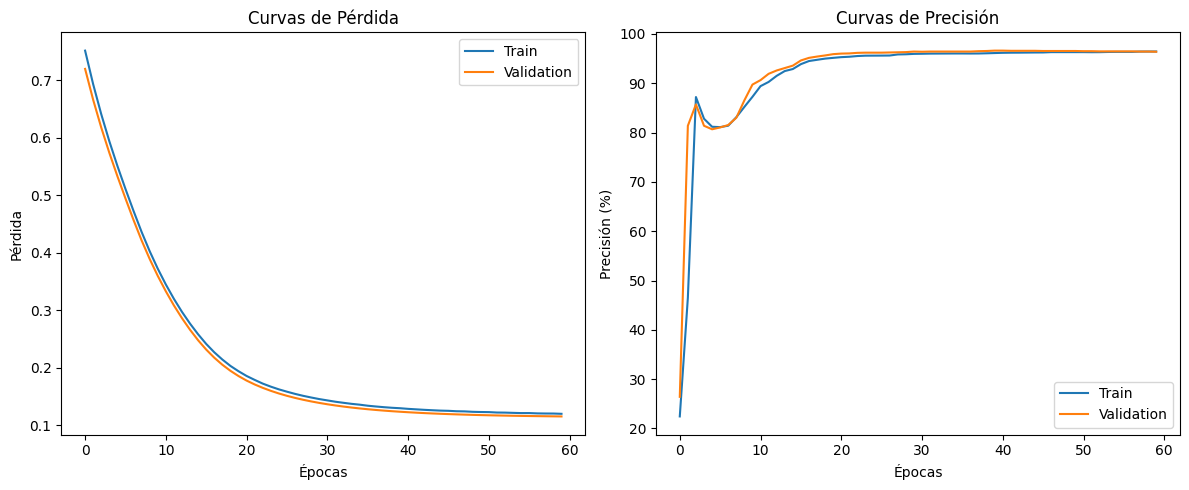

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Predicciones

In [ ]:
traveller_map = {
    "Solo": 0,
    "Family": 1,
    "Business": 2,
    "Couple": 3
}
inverse_traveller_map = {v: k for k, v in traveller_map.items()}
def predict_example(model, data, target, feature_names):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.FloatTensor(data).to(device)
        output = model(data_tensor.unsqueeze(0))
        prob = torch.sigmoid(output)
        predicted = (prob > 0.57).long()
        
    print("\nEjemplo de predicción:")
    for i, (name, value) in enumerate(zip(feature_names, data)):
        if name == "type_traveller":
            tipo = inverse_traveller_map[int(round(value))]
            print(f"{name}: {tipo}")
        else:
            print(f"{name}: {value:.2f}")
    
    print(f"\nProbabilidad de recomendar: {prob.item():.2f}")
    print(f"Predicción: {'Recomendar' if predicted.item() == 1 else 'No recomendar'}")
    print(f"Real: {'Recomendar' if target == 1 else 'No recomendar'}")

feature_names = [
    "type_traveller", "overall_rating", "queuing_rating", 
    "terminal_cleanliness", "food_beverages", "airport_shopping", 
    "wifi_connectivity"
]

sample_idx = np.random.randint(len(test_dataset))
sample_data, sample_target = test_dataset[sample_idx]
predict_example(model, sample_data.numpy(), sample_target.item(), feature_names)


Ejemplo de predicción:
type_traveller: Solo
overall_rating: 1.57
queuing_rating: 0.11
terminal_cleanliness: 0.59
food_beverages: -0.07
airport_shopping: 0.05
wifi_connectivity: -0.05

Probabilidad de recomendar: 0.71
Predicción: Recomendar
Real: Recomendar
